# Homework 1: Sofi Vinas

In [1]:
%load_ext tensorboard

In [2]:
import torch
import torchvision
from torchvision import transforms as T
from torchvision import datasets
from torchvision import models

from torch.utils.data import DataLoader
from torch.utils.data import sampler, random_split

# a bunch of image net models, pretrained, also has good training/evaluation scripts that are highly optimized
import timm
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm # This is optional but useful

In [3]:
# using tensorboard for visualization

In [4]:
# loading libraries that contain a bunch of helper functions

In [5]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [6]:
# using matplotlib from Steven's demo (to visually see the data from the dataset)

In [7]:
# loading the dataset, changed the number of workers from 12 to 0 (per generated warning)

In [8]:
transform = T.ToTensor()
trainset = torchvision.datasets.CIFAR10('../Datasets', download=True, transform=transform)
train = torch.utils.data.DataLoader(trainset, batch_size=32, num_workers=0)

expand_transform = T.Compose([T.Resize(256), T.ToTensor()])
trainset_256 = torchvision.datasets.CIFAR10('../Datasets', download=True, transform=expand_transform)
train_256 = torch.utils.data.DataLoader(trainset_256, batch_size=32, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


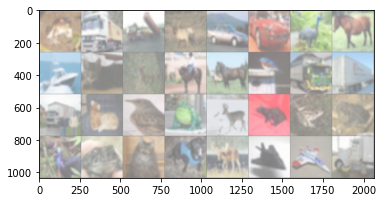

In [9]:
dataiter = iter(train)
imgs,labels = dataiter.next()
img_grid = torchvision.utils.make_grid(imgs)
matplotlib_imshow(img_grid)

dataiter_256 = iter(train_256)
imgs_256, labels_256 = dataiter_256.next()
img_grid_256 = torchvision.utils.make_grid(imgs_256)
matplotlib_imshow(img_grid_256)

# Getting the Data

In [10]:
cifar_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )
train_data = DataLoader(cifar_dataset,
                        batch_size=2,
                        )

Files already downloaded and verified


https://pytorch.org/vision/stable/datasets.html#cifar

In [11]:
# the cifar10 dataset has been loaded into our directory

# Looking Into the Data

In [12]:
data = iter(train_data) # Let's iterate on it
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")

Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([2, 3, 32, 32]), torch.Size([2])
Labels: tensor([6, 9])



In [13]:
# so our data is organized as a "list" (data,label) hence length 2
# both of type tensor because of our transformation

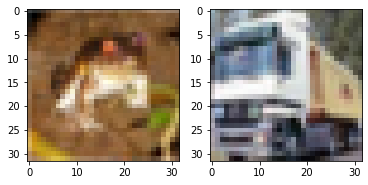

In [14]:
ToPIL = T.ToPILImage() # Converting function
image0 = ToPIL(single_point[0][0])
image1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
# using our above imshow function
axs[0].imshow(image0)
axs[1].imshow(image1)

In [15]:
# here we can see some of the data (2 images of what appears to be a frog and a truck?)

# Linear Classifier on CIFAR10

In [16]:
class SimpleNet(nn.Module):
    def __init__(self, ninputs=28*28, nhidden=512, nout=10,):
        super().__init__()
        self.net=nn.Sequential(
            nn.Linear(ninputs, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nout),
            nn.ReLU(),
        )
        
    def forward(self,x):
        b,c,h,w=x.shape
        x=x.view(b,-1) # we do this to flatten the image
        x=self.net(x)
        return x

In [17]:
# now let's do some training on our model

In [18]:
# let's get the right torch device (preference of GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# setting up some important parameters needed for training
# this will be our default learning rate (I found that the higher the learning rate, the longer the epochs took)
learningRate=0.001
# like cycles, total iterations (originally 10, trying 50 next!)
numEpochs = 10
# 3 layers of 32 by 32 images
ninputs=3*32*32
# 1024 hidden layers in the network
nhidden=256
# 10 image classes for cifar10 dataset
nout=10 

# the deeper the network, the better the training error

# our model in this run will be the LinearNet we defined above. We can easily change this whenever we want, and modify certain parameters.
model = SimpleNet(ninputs=ninputs,
                  nhidden=nhidden,
                  nout=nout).to(device)

# let's print the model to make sure everything is running smoothly
print(model)


# now let's implement an optimizer (to see what kind of gradient descent we need)
# in this case averaged stochastic gradient descent (I want to try ADAM NEXT!)
optimizer = optim.ASGD(model.parameters(), lr=learningRate)


# we will use cross entropy loss as the loss function, to measure how well our model is doing (whether or not the predictions are accurate)
LossFunction = nn.CrossEntropyLoss()


# we can change this later 
batch_size = 200 

transforms = T.Compose([T.ToTensor()])

cifar_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

train_data = DataLoader(cifar_dataset,
                        batch_size=batch_size,
                        )

# This is default on but let's just be pedantic
model.train()
loss_history = []
loss = torch.Tensor([0])
for epoch in tqdm(range(numEpochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True) # Here we clear the gradients or else they add up, we don't want that
        
        # We need to make sure the tensors are on the same device as our model
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        
        loss = LossFunction(out, label)
        
        # PyTorch is Magic!
        loss.backward() # This function calculates all our gradients
        optimizer.step() # This function does our gradient descent with those gradients
        loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")

SimpleNet(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=10, bias=True)
    (5): ReLU()
  )
)
Files already downloaded and verified


Epoch:  10%|███▍                              | 1/10 [00:26<03:55, 26.12s/epoch]

Epoch 0: loss: 2.2954986095428467


Epoch:  20%|██████▊                           | 2/10 [00:54<03:37, 27.22s/epoch]

Epoch 1: loss: 2.2908546924591064


Epoch:  30%|██████████▏                       | 3/10 [01:22<03:12, 27.54s/epoch]

Epoch 2: loss: 2.2863502502441406


Epoch:  40%|█████████████▌                    | 4/10 [01:47<02:40, 26.73s/epoch]

Epoch 3: loss: 2.2819483280181885


Epoch:  50%|█████████████████                 | 5/10 [02:13<02:12, 26.44s/epoch]

Epoch 4: loss: 2.2774226665496826


Epoch:  60%|████████████████████▍             | 6/10 [02:43<01:50, 27.69s/epoch]

Epoch 5: loss: 2.272827386856079


Epoch:  70%|███████████████████████▊          | 7/10 [03:10<01:22, 27.52s/epoch]

Epoch 6: loss: 2.268143653869629


Epoch:  80%|███████████████████████████▏      | 8/10 [03:35<00:53, 26.74s/epoch]

Epoch 7: loss: 2.26328444480896


Epoch:  90%|██████████████████████████████▌   | 9/10 [04:04<00:27, 27.48s/epoch]

Epoch 8: loss: 2.2583558559417725


Epoch: 100%|█████████████████████████████████| 10/10 [04:31<00:00, 27.12s/epoch]

Epoch 9: loss: 2.2533037662506104


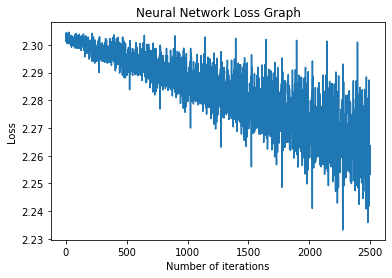

Files already downloaded and verified
Total accuracy is 19.24%


In [19]:
# Note that we are not plotting loss per epoch but per iteration
plt.plot(loss_history)
plt.title("Neural Network Loss Graph")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

# We need to do the test data now
cifar_test_dataset = datasets.CIFAR10(root='./', train=False, download=True, transform=T.ToTensor(),)
test_data = DataLoader(cifar_test_dataset, batch_size=batch_size,)

model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy is {accuracy / len(cifar_test_dataset)*100:.2f}%")

In [20]:
# some more sample models

In [21]:
class LinearNet(nn.Module):
    def __init__(self,
                 ninputs=3*32*32,
                 nhidden=512,
                 nout=10,
                ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, nhidden, bias=True),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nout, bias=True),
            nn.ReLU(),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1) # let's flatten the images
        x = self.net(x)
        return x

# Trying Different Regression Models

In [22]:
class LogisticNet(nn.Module):
    def __init__(self,
                 ninputs=3*32*32,
                 nhidden=512,
                 nout=10,
                ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, nhidden, bias=True),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nout, bias=True),
            nn.ReLU(),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1)
        # using sigmoids for our logistic regression
        x = torch.sigmoid(self.net(x))
        return x

In [23]:
# we are using the ReLU regularization technique in this linear model

In [24]:
# we are also ommitting the bias term in our softmax model 

In [25]:
class SoftmaxNet(nn.Module):
    def __init__(self,
                 ninputs=28*28,
                 nhidden=512,
                 nout=10,
                ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, nhidden, bias=False),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nout, bias=False),
            nn.ReLU(),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1) #flattening the images again
        x = F.softmax(self.net(x), dim=1)
        return x

In [26]:
# Let's get the right torch device (preference of GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Let's set up some parameters
learning_rate=0.001
nepochs = 10
ninputs=3*32*32
nhidden=1024
nout=10


# trying LogistNet now with Adam optimizer
model = LogisticNet(ninputs=ninputs, nhidden=nhidden, nout=nout).to(device)
#model = LeNet().to(device)
#model = torchvision.models.vgg19(pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

print(model)

# We need an optimizer that tells us what form of gradient descent to do
optimizer = torch.optim.ASGD(model.parameters(), learning_rate)

# We also need a loss function
LossFunction = nn.CrossEntropyLoss()

batch_size = 200


# this should be updated with transformations above (data augmentation)
cifar_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )

train_data = DataLoader(cifar_dataset,
                        batch_size=batch_size,
                        )
# This is default on but let's just be pedantic
model.train()
loss_history = []
loss = torch.Tensor([0])
for epoch in tqdm(range(nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True) # Here we clear the gradients
        
        # We need to make sure the tensors are on the same device as our model
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        
        loss = LossFunction(out, label)
        
        loss.backward() # This function calculates all our gradients
        optimizer.step() # This function does our gradient descent with those gradients
        loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")


LogisticNet(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=10, bias=True)
    (7): ReLU()
  )
)
Files already downloaded and verified


Epoch:  10%|███▍                              | 1/10 [01:03<09:32, 63.66s/epoch]

Epoch 0: loss: 2.302429437637329


Epoch:  20%|██████▊                           | 2/10 [02:07<08:29, 63.74s/epoch]

Epoch 1: loss: 2.302356481552124


Epoch:  30%|██████████▏                       | 3/10 [03:07<07:15, 62.20s/epoch]

Epoch 2: loss: 2.302269220352173


Epoch:  40%|█████████████▌                    | 4/10 [04:10<06:15, 62.52s/epoch]

Epoch 3: loss: 2.3021795749664307


Epoch:  50%|█████████████████                 | 5/10 [05:14<05:14, 62.80s/epoch]

Epoch 4: loss: 2.3020968437194824


Epoch:  60%|████████████████████▍             | 6/10 [06:15<04:09, 62.35s/epoch]

Epoch 5: loss: 2.3020172119140625


Epoch:  70%|███████████████████████▊          | 7/10 [07:14<03:04, 61.37s/epoch]

Epoch 6: loss: 2.3019285202026367


Epoch:  80%|███████████████████████████▏      | 8/10 [08:13<02:01, 60.53s/epoch]

Epoch 7: loss: 2.3018410205841064


Epoch:  90%|██████████████████████████████▌   | 9/10 [09:16<01:01, 61.26s/epoch]

Epoch 8: loss: 2.3017539978027344


Epoch: 100%|█████████████████████████████████| 10/10 [10:22<00:00, 62.20s/epoch]

Epoch 9: loss: 2.3016653060913086


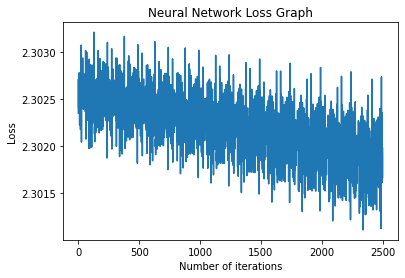

Files already downloaded and verified
Total accuracy is 12.35%


In [27]:
# Note that we are not plotting loss per epoch but per iteration
plt.plot(loss_history)
plt.title("Neural Network Loss Graph")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

# We need to do the test data now
cifar_test_dataset = datasets.CIFAR10(root='./', train=False, download=True, transform=T.ToTensor(),)
test_data = DataLoader(cifar_test_dataset, batch_size=batch_size,)

model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy is {accuracy / len(cifar_test_dataset)*100:.2f}%")

# Convolutional Neural Networks

In [28]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # change the input channels from 1 to 3
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)
        # 10 output channels for the classes

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.avg_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.avg_pool2d(out, 2)
        # out.size() = [batch_size, channels, size, size], -1 here means channels*size*size
        # out.view(out.size(0), -1) is similar to out.reshape(out.size(0), -1), but more efficient
        # Think about why we need to reshape the out?
        out = out.view(out.size(0), -1) 
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [29]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

# Let's use a Convolutional Neural Network on CIFAR10 with Data Augmentation

https://pytorch.org/docs/stable/optim.html

In [30]:
# SGD (STOCHASTIC GRADIENT DESCENT)

In [31]:
# let's get the right torch device (preference of GPU)
use_cuda = torch.cuda.is_available()  # Check if GPU available 
print("Use GPU?", use_cuda)

model = LeNet()

if use_cuda:
  model = model.cuda()  # transfer model to GPU


samplebatch_size = 128
# loss function
loss_function = nn.CrossEntropyLoss()

# learning rate update function
def adjust_learning_rate(optimizer, nepochs, init_lr):
    #lr = 1.0 / (epoch + 1) 
    lr = init_lr * 0.1 ** (nepochs // 10)  
    # epoch // 10, calculate the quotient 
    # divide lr by 10 every 10 epoches
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

init_lr = 0.1
nepochs = 15
# we were testing with 30 but that was taking forever, so I trimmed it down to 15
optimizer = optim.SGD(model.parameters(), lr=init_lr, weight_decay = 0.0001)


print(model)
# Step 2: Define a loss function and training algorithm
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(my_model.parameters(), lr=lr)


# Step 3: load dataset, perform data augmentation with transforms

CIFAR10_transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))])

trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=CIFAR10_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=samplebatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./', train=False, download=True, transform=CIFAR10_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# that's why we use 10 as our output 

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.

for epoch in range(nepochs):
    current_lr = adjust_learning_rate(optimizer, epoch, init_lr)
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = model(images) 
        loss = loss_function(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
        
    # Training accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()  
        outputs = model(images)
        p_max, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()
    training_accuracy = round(float((correct)/total)*100,2)

    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()
        outputs = model(images)
        p_max, predicted = torch.max(outputs, 1) 
        total += labels.size(0)
        correct += (predicted == labels).sum()
    test_accuracy = round(float((correct)/total)*100,2)
        
    
    print('Epoch: {}, Training accuracy: {}, Test accuracy: {}' .format(epoch+1,training_accuracy,test_accuracy))  

Use GPU? False
LeNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, Training accuracy: 37.29, Test accuracy: 37.85
Epoch: 2, Training accuracy: 44.79, Test accuracy: 44.5
Epoch: 3, Training accuracy: 48.35, Test accuracy: 47.07
Epoch: 4, Training accuracy: 53.9, Test accuracy: 51.05
Epoch: 5, Training accuracy: 56.47, Test accuracy: 53.27
Epoch: 6, Training accuracy: 58.28, Test accuracy: 54.68
Epoch: 7, Training accuracy: 59.36, Test accuracy: 54.77
Epoch: 8, Training accuracy: 62.32, Test accuracy: 56.02
Epoch: 9, Training accuracy: 64.83, Test accuracy: 57.96
Epoch: 10, Training accuracy: 64.54, Test accuracy: 57.63
Epoch: 11, Training accuracy:

In [32]:
# each epoch has improved training accuracy and improved testing accuracy!

# Fine Tuning ResNet-50 Model

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html

In [33]:
# Freeze the weights up to some point and only train the last couple of layers

In [34]:
# Initialize the pretrained model
# Reshape the final layer(s) to have the same number of outputs as the number of classes in the new dataset
# Define for the optimization algorithm which parameters we want to update during training
# Run the training step

In [ ]:
# I decided to use google colab after working on different methods for a bit, I just thought this was the easiest way in my opinion to work on the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# I used my google drive to hold the downloaded dataset, and organized my folders there
# everything I need to use is in this CUB_200_2011 folder
classes = pd.read_csv('/content/drive/My Drive/CUB_200_2011/classes.txt', sep=" ", header=None)[1].values
data_dir = "/content/drive/My Drive/CUB_200_2011/"

batch_size = 100
transformation_train = T.Compose([
    T.Resize((256,256)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    T.ColorJitter(brightness=1, contrast=1, saturation=1),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
 
transformation_validation = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transformation_test = T.Compose([
    T.Resize((256,256)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# importing dataset
train_dataset = datasets.ImageFolder(root= str(data_dir) + "Train",      transform=transformation_train)
valid_dataset = datasets.ImageFolder(root= str(data_dir) + "Validation", transform=transformation_validation)
test_dataset  = datasets.ImageFolder(root= str(data_dir) + "Test",       transform=transformation_test)

# constructing data loaders.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

In [ ]:
print(train_dataset)
print("----------------------------------------------------")
print("")
print(valid_dataset)
print("----------------------------------------------------")
print("")
print(test_dataset)

In [ ]:
# let's create some plotting functions for the bird images
def convert_img(tensor_image):
    np_image = tensor_image.clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image


# plots an image.
def convert_img_cuda(tensor_image):
    np_image = tensor_image.cpu().clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

In [ ]:
# let's see what some of the images look like

In [ ]:
train_iterator = iter(train_loader)
train_images, train_labels = train_iterator.next()
print("Printing Sizes Below:")
print("----------------------")
print(train_labels.shape)
print(train_images.shape)

In [ ]:
figure = plt.figure(figsize=(28,8))    

for i in range(30):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img(train_images[i])
    title = classes[ train_labels[i] ]
    plt.imshow(image) 
    plt.title(title)
    plt.axis('off')

plt.show()

In [ ]:
# we'll be finetuning the resnet50 model now (using torchvision's pretrained models)

In [ ]:
# defining the Resnet50 model to use on our data
class ResNet50(nn.Module):
  
    # constructor (make sure to call super)
    def __init__(self):
        super().__init__()
        self.model = models.resnet50(pretrained=True)
        last_layer_inputs = self.model.fc.in_features
        self.model.fc = nn.Linear(last_layer_inputs, 200)  
        self.model.to(device)

    def forward(self, x):
        x = self.model.forward(x)
        return x

In [ ]:
# let's use cross entropy loss as our loss function like we did for the other models
# and continue using stochastic gradient descent for our optimizer
# setting the learning rate right now to 0.1 (can be changed later)

resnet_model = ResNet50()
loss_function_resnet = nn.CrossEntropyLoss()
optimizer_resnet = torch.optim.SGD(resnet_model.parameters(), lr=0.1)

In [ ]:
def train_model(loss_function, optimizer, model):
    train_loss = 0.0
    train_acc = 0.0
    test_acc_5 = 0.0
  
    # training the model with the train dataset.
    for train_images, train_labels in train_loader:
    
        # registering train images and labels 
        # to device to benefit from GPU
        train_images = train_images.to( device )
        train_labels = train_labels.to( device )   

        # calculating loss for training
        # dataset for the current batch.
        # call the forward function we created above for the resnet50 model
        train_labels_head = model.forward(train_images)
        loss = loss_function(train_labels_head, train_labels)

        # updating weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
        # calculating acurracy for the current
        # batch for the training dataset.
        predictions = torch.max(train_labels_head , 1)[1] 
        acurracy = torch.sum(predictions == train_labels )
        
        # summing training acurracy and 
        # loss wit the remaining batches.
        train_acc += acurracy 
        train_loss += loss.item()
    
    return train_loss, train_acc

In [ ]:
def validate_model(loss_function, model):
    valid_loss = 0.0
    valid_acc  = 0.0

    # testing the current model within the current epoch.
    for valid_images, valid_labels in valid_loader:
        
        # registering test images and labels 
        # to device to benefit from GPU
        valid_images = valid_images.to(device)
        valid_labels = valid_labels.to(device)
        
        # calculating loss for test 
        # dataset for the current batch.
        valid_labels_head = model.propagate_forward(valid_images)
        loss = loss_function(valid_labels_head, valid_labels)
    
        # calculating acurracy for the cur-
        # rent batch for the test dataset.
        predictions = torch.max(valid_labels_head , 1)[1] 
        acurracy = torch.sum(predictions == valid_labels)
    
        # summing test acurracy and 
        # loss wit the remaining batches.
        valid_acc  += acurracy 
        valid_loss += loss.item()

    return valid_loss, valid_acc

In [ ]:
# running 15 epochs as I had originally took WAY too long and I ran out of RAM
nepochs = 5
train_count = 8190
valid_count = 2311
train_resnet_losses = []
valid_resnet_losses = []
train_resnet_acurracies = []
valid_resnet_acurracies = []

# training with the number of epochs.
for epoch in range(nepochs):
    train_loss = 0.0
    valid_loss = 0.0
    train_acc = 0.0
    valid_acc = 0.0
  
    # training the model with the train dataset.
    train_loss, train_acc = train_model(loss_function_resnet, optimizer_resnet, resnet_model)
    
    # validating the current model within the current epoch.
    valid_loss, valid_acc = validate_model(loss_function_resnet, resnet_model)

    # printing out the training dataset 
    # results for the current batch.
    # let's round 2 decimal places 
    print("EPOCH --> " + str(epoch + 1))
    print("----------------------------------------------") 
    train_acc = round(float(train_acc.float()) / train_count,2)
    train_resnet_acurracies.append(train_acc)
    print("Train Acurracy: " + str(float(train_acc)))
    
    train_loss = (train_loss / train_count)
    train_resnet_losses.append(train_loss)
    print("Train Loss: " + str(train_loss) + "\n")

    valid_acc = round(float(valid_acc.float()) / valid_count,2)
    valid_resnet_acurracies.append(valid_acc)
    print("Validation Acurracy: " + str( float(valid_acc)))    
    
    valid_loss = round(valid_loss / valid_count,2)
    valid_resnet_losses.append( valid_loss )
    print("Validation Loss: " + str(valid_loss))
    print("----------------------------------------------\n")